In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
!pip install fiona
!pip install rasterio
!pip install geopandas
import fiona
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
!pip install xlrd==1.2.0
import xlrd
import pandas as pd
import requests
import datetime
import json
import math
import cv2
!pip install pyproj
from pyproj import Proj,transform

from scipy.optimize import curve_fit
from dateutil.parser import parse
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from xlrd import xldate_as_tuple
from datetime import datetime
import scipy

In [ ]:
import ee
ee.Authenticate() # import and anthenticate EE
ee.Initialize() # initialize the ee library

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=b7yyYPnG3dpsIjuji-rm1Oieym5Q4x8m1kqtz4e839k&tc=4EPv7VVYbJR2fDcLLQZ39KilxM2TRu_aZQjv-D-cl50&cc=KCjym3LgvLpQ-KjfNx5IpWrPrCI1JtH8dEGwqNxQu9Q

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BXw110gqXNFaRn2hNuwQnCMKHQTH_8M_l2FcSKrKKIjh7vEUhhiHgU

Successfully saved authorization token.


In [ ]:
Whanganui_RS = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2015-01-01','2023-08-07').filterBounds(ee.Geometry.Point([172.78,-40.39])).filter('CLOUDY_PIXEL_PERCENTAGE < 10')  ##Filter images with high cloud coverage ## Make sure the Geometry point is in the center of satellite images
print(Whanganui_RS.size().getInfo()) ###the number of the qualified images
###PLEASE BE VERY CAREFUL ABOUT THE GEOMETRY POINT YOU USE HERE.
##Sometimes the geometry point you use is in the overlapped area of two images (See below). If you look for Tauranga Harbour: Plz use this location:176.05 -37.62

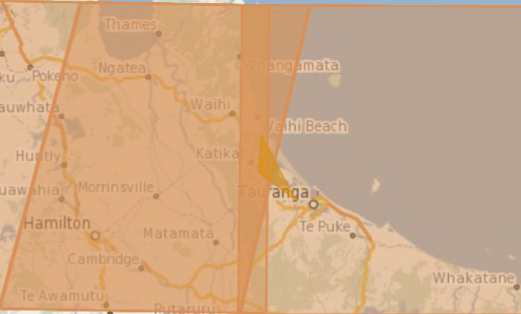

In [ ]:
Whanganui_RS_id = []  ##Get the ID of satellite image with a low cloud coverage
nimg=Whanganui_RS.size().getInfo()
colList = Whanganui_RS.toList(nimg);
n = colList.size().getInfo();
for i in range(0,nimg):
    img = ee.Image(colList.get(i));
    id = img.id().getInfo();
    Whanganui_RS_id.append(id)

In [ ]:
Whanganui_RS_id

['20181215T222531_20181215T222536_T59GPR',
 '20190104T222531_20190104T222532_T59GPR',
 '20190114T222531_20190114T222533_T59GPR',
 '20190213T222531_20190213T222534_T59GPR',
 '20190330T222539_20190330T222539_T59GPR',
 '20190623T222541_20190623T222542_T59GPR',
 '20190906T222539_20190906T222539_T59GPR',
 '20191205T222539_20191205T222538_T59GPR',
 '20191220T222541_20191220T222549_T59GPR',
 '20191225T222539_20191225T222539_T59GPR',
 '20200218T222541_20200218T222538_T59GPR',
 '20200228T222541_20200228T222539_T59GPR',
 '20200304T222539_20200304T222541_T59GPR',
 '20200329T222541_20200329T222616_T59GPR',
 '20200403T222539_20200403T222541_T59GPR',
 '20200423T222539_20200423T222538_T59GPR',
 '20200423T222539_20200423T222712_T59GPR',
 '20200428T222551_20200428T222547_T59GPR',
 '20200508T222551_20200508T222548_T59GPR',
 '20200622T222549_20200622T222546_T59GPR',
 '20200811T222549_20200811T222547_T59GPR',
 '20200821T222549_20200821T222547_T59GPR',
 '20200910T222549_20200910T222546_T59GPR',
 '20201015T

In [ ]:
from datetime import datetime, timedelta
def convert_to_nz_time(gmt_time):
    nzst_offset = 12  # NZST offset from GMT
    nzdt_offset = 13  # NZDT offset from GMT

    # Define the daylight saving time range (last Sunday in September to first Sunday in April)
    dst_start = datetime(gmt_time.year, 9, 30)
    dst_end = datetime(gmt_time.year, 4, 1)
    dst_start = dst_start + timedelta(days=(6 - dst_start.weekday()))  # Find the last Sunday in September
    dst_end = dst_end + timedelta(weeks=1)  # Find the first Sunday in April

    if dst_start <= gmt_time < dst_end:
        nz_offset = nzdt_offset
    else:
        nz_offset = nzst_offset

    nz_time = gmt_time + timedelta(hours=nz_offset)
    return nz_time

In [ ]:
gmttime = str(datetime(int(Whanganui_RS_id[0][0:4]),int(Whanganui_RS_id[0][4:6]),int(Whanganui_RS_id[0][6:8]),22,16,00))
gmttime

'2018-12-15 22:16:00'

In [ ]:
def season(time):
  if int(time[5:7])<9 and int(time[5:7])>4:
    return "summer"
  else:
    return "winter"

In [ ]:
def get_niwa_tide(lat,long,date,time,Timezone):  ##Based on Ted's estuarine model.
  import datetime
  #please make sure date and time are typed in the form of str
  date_num = datetime.datetime.strptime(date,'%Y-%m-%d')
  water_level = []   # initialize arrays
  water_level_time =[]
  parameters = {
      "lat": lat,
      "long": long,
      "datum": "MSL",
      "interval": 10,
      "numberOfDays": 2,
      "apikey": "yeLjOeJB5LtqHyO7EH7hLwhlC0RffrnX",
      "startDate": date}
    # get data
  response = requests.get("https://api.niwa.co.nz/tides/data", params=parameters)
  response_values = response.json()['values']
  for d in response_values:
    water_level.append(d['value'])
    t = str(d['time'])
    t = t.replace("T","")
    t = t.replace("Z","")
    if Timezone == "winter":
      t = datetime.datetime.strptime(t,'%Y-%m-%d%H:%M:%S')+datetime.timedelta(0.5)
    if Timezone == "summer":
      t = datetime.datetime.strptime(t,'%Y-%m-%d%H:%M:%S')+datetime.timedelta(hours=13)
    water_level_time.append(t)
  time_tide = [water_level_time,water_level]
  d = pd.DataFrame()
  d['time'] = time_tide[0]
  d['tide'] = time_tide[1]
  d.set_index('time',inplace=True)
  df_reindexed = d.reindex(pd.date_range(start=d.index.min(),end=d.index.max(),freq='1min'))
  df_reindexed['tide']= df_reindexed.interpolate(method='cubic')
  m = df_reindexed.loc[date + ' '+ time]
  tide_height = float(str(m)[6:12]) ## I converted the data type from pdframe to str
  return tide_height

In [ ]:
filtered_dates = []   ##exclude the image with tide height over than -0.5m (MSL)
for i in range(len(Whanganui_RS_id)):
  gmttime = str(datetime(int(Whanganui_RS_id[i][0:4]),int(Whanganui_RS_id[i][4:6]),int(Whanganui_RS_id[i][6:8]),22,16,00))
  if get_niwa_tide(-40.585,172.535,gmttime[0:10],gmttime[11:23],season(gmttime))<-0.5: ###change the number here to have a differnt tide height
    filtered_dates.append(Whanganui_RS_id[i])


In [ ]:
import json  ##Clip the satellite image
gjson_path = '/content/gdrive/My Drive/Whanganui/whanganui_inlet.geojson'  #Import the geojson of whanganui, geojson can be transformed from shapefile
with open(gjson_path) as f:
    gjson = json.load(f)
features = gjson['features']
fc = ee.FeatureCollection(features)  ## the geo-coordinate system here should be WGS84 EPSG: 4326

In [ ]:
cwd = os.getcwd() ###Make sure the routine is located in the folder where you want to export the data
os.chdir('/content/gdrive/My Drive/Whanganui/')

In [ ]:
for i in range(len(filtered_dates)):   ###export all the images at low tides
  path =  "COPERNICUS/S2_SR/" + filtered_dates[i]
  img = ee.Image(path)
  B2 = img.select('B2')
  B2_clip = B2.clipToCollection(fc)
  task = ee.batch.Export.image.toDrive(**{
    'image': B2_clip,
    'description': filtered_dates[i][0:8]+'_B2',
    'folder': 'B2',
    'scale': 10,
    'region': fc.geometry()})
  task.start()

  B3 = img.select('B3')
  B3_clip = B3.clipToCollection(fc)
  task = ee.batch.Export.image.toDrive(**{
    'image': B3_clip,
    'description': filtered_dates[i][0:8]+'_B3',
    'folder': 'B3',
    'scale': 10,
    'region': fc.geometry()})
  task.start()

  B4 = img.select('B4')
  B4_clip = B4.clipToCollection(fc)
  task = ee.batch.Export.image.toDrive(**{
    'image': B4_clip,
    'description': filtered_dates[i][0:8]+'_B4',
    'folder': 'B4',
    'scale': 10,
    'region': fc.geometry()})
  task.start()

  B8 = img.select('B8')
  B8_clip = B8.clipToCollection(fc)
  task = ee.batch.Export.image.toDrive(**{
    'image': B8_clip,
    'description': filtered_dates[i][0:8]+'_B8',
    'folder':'B8',
    'scale': 10,
    'region': fc.geometry()})
  task.start()

In [ ]:
###Try the following scripts to composite each band into one tif file
### Or you can use the function called "Composite Bands" in Arcmap. Make sure the order when compositing is Band Blue, Green, Red and NIR
import arcpy

compband_raster = arcpy.ia.CompositeBand(["Band1.TIF", "Band2.TIF", "Band3.TIF"])

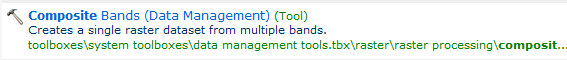